In [1]:
import scipy.stats as stats

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.preprocessing import SplineTransformer, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from sklearn.pipeline import Pipeline

from typing import Any

SEED = 2058
NCALLS = 2

params = [
    {
        'ensemble': [
            VotingRegressor(
                [
                    ('svm', SVR()),
                    ('rf', RandomForestRegressor()),
                    ('ada', AdaBoostRegressor()),
                    ('lgbm', LGBMRegressor())
                ]
            )
        ],
        'spline__n_knots': stats.randint(5, 20),
        'spline__degree': stats.randint(2, 5),

        'ensemble__svm__kernel': ['rbf', 'sigmoid'],
        'ensemble__svm__gamma': stats.uniform(1e-5, 1),
        'ensemble__svm__C': stats.uniform(1e-5, 1e4),
        'ensemble__svm__epsilon': stats.uniform(1e-5, 1e4),
        'ensemble__svm__max_iter': [10000],

        'ensemble__ada__n_estimators': [50 + i for i in range(0, 300, 50)],
        'ensemble__ada__learning_rate': stats.uniform(1e-5, 1e3),
        'ensemble__ada__loss': ['linear', 'square', 'exponential'],

        'ensemble__rf__n_estimators': [50 + i for i in range(0, 400, 50)],
        'ensemble__rf__max_depth': stats.randint(4, 16),
        'ensemble__rf__min_samples_split': stats.randint(2, 20),
        'ensemble__rf__min_samples_leaf': stats.randint(2, 20),
        'ensemble__rf__max_features': ['sqrt', 'log2', 1.0],
        'ensemble__rf__min_impurity_decrease': stats.uniform(1e-3, 1),
        'ensemble__rf__ccp_alpha': stats.uniform(1e-3, 1e2),

        'ensemble__lgbm__n_estimators': [i for i in range(500, 3000, 1000)],
        'ensemble__lgbm__max_depth': stats.randint(4, 16),
        'ensemble__lgbm__min_child_weight': stats.randint(1, 6),
        'ensemble__lgbm__learning_rate': stats.uniform(1e-5, 1),
        'ensemble__lgbm__reg_alpha': stats.uniform(1e-5, 1e2),
        'ensemble__lgbm__reg_lambda': stats.uniform(1e-5, 1e2),
        'ensemble__lgbm__verbosity': [-1],
    }
]

ensemble = VotingRegressor(
    estimators=[
        ('svm', SVR()),
        ('rf', RandomForestRegressor()),
        ('ada', AdaBoostRegressor()),
        ('lgbm', LGBMRegressor())
    ]
)

pipeline = Pipeline(
    [
        ('power-transformer', PowerTransformer()),
        ('spline', SplineTransformer(n_knots=10)),
        ('ensemble', 'passthrough')
    ]
)

def scorer(estimator, X, y):
    return -mean_absolute_percentage_error(y_true=y, y_pred=estimator.predict(X))

In [2]:
import sys, os
import matplotlib.pyplot as plt
import warnings
import numpy as np

sys.path.append(os.getcwd() + "/../src/")

from utils import create_dataset

btc = create_dataset()
btc = btc.reset_index(drop=True)

X_pred = btc.iloc[-1].drop(['Date', 'target'])
btc = btc.dropna()

X, y = btc.drop(columns=['target', 'Date']).astype(np.float64), btc['target'].astype(np.float64)

In [ ]:
ts_cv = TimeSeriesSplit(
    n_splits=10,
    test_size=1
)

cv = RandomizedSearchCV(
    pipeline,
    param_distributions=params,
    n_iter=NCALLS,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=ts_cv
)

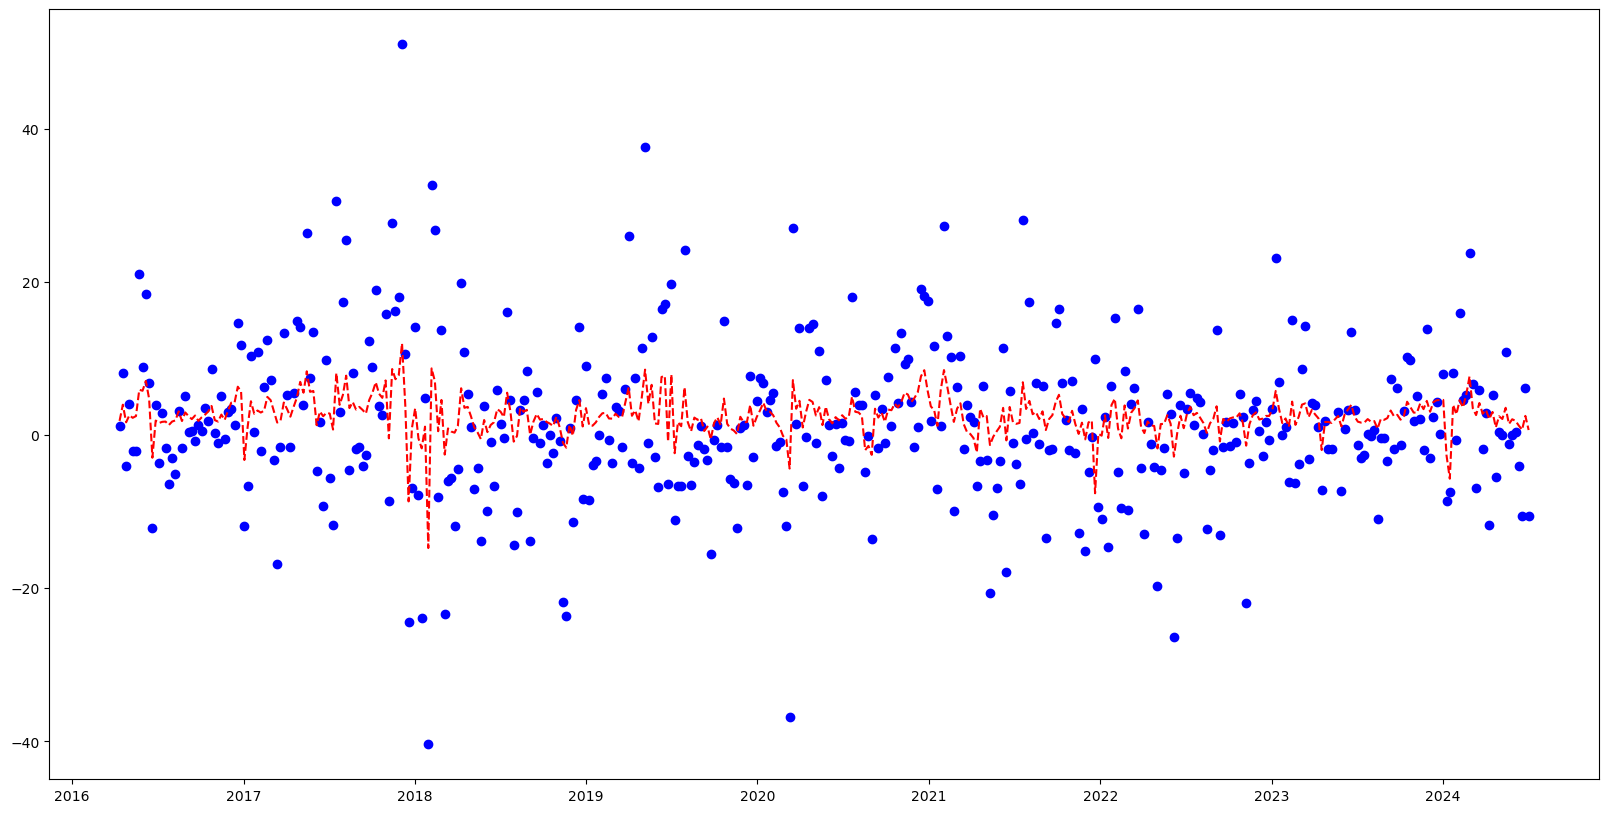

In [5]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    res.best_estimator_.fit(X, y)
    y_pred = res.predict(X)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(btc['Date'], btc['target'], c='b')
ax.plot(btc['Date'], y_pred, c='r', linestyle='--')
fig.show()

In [6]:
print("----- MAPE -----")
print(f"{mean_absolute_percentage_error(btc['target'], y_pred)}")
print("----- R2 ------")
print(f"{r2_score(btc['target'], y_pred)}")

----- MAPE -----
2.174180561555871
----- R2 ------
0.3452387671380871


In [ ]:
import pickle

with open("./best_estimator.pkl", "rb") as fp:
    pickle.dump(res.best_estimator_, fp)